# TODO：概要

# ライブラリのインポート

In [1]:
import os
import time
import json
import datetime
import zoneinfo

import requests

from dotenv import load_dotenv, find_dotenv

from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import (
    MessageTextContent,
    ListSortOrder,
    McpTool,
    MCPToolDefinition,
    RequiredMcpToolCall,
    SubmitToolApprovalAction,
    ToolApproval,
    CodeInterpreterTool,
    FunctionTool,
    ToolSet,
)
from IPython.display import Image, display

# 環境変数の取得

In [2]:
load_dotenv(override=True)

PROJECT_ENDPOINT=os.getenv("PROJECT_ENDPOINT")
AZURE_DEPLOYMENT_NAME=os.getenv("AZURE_DEPLOYMENT_NAME")

# クライアントの初期化

In [3]:
# AI Project Client を初期化
project_client = AIProjectClient(
    endpoint=PROJECT_ENDPOINT,
    credential=DefaultAzureCredential()
)

# ユーティリティ関数

In [4]:
def agent_run_outputs(thread_id, project_client, target_dir="./output_images"):
    """
    指定したスレッドIDのRun実行結果（テキスト・画像）をNotebook上に表示＆画像は保存。
    """
    messages = project_client.agents.messages.list(thread_id=thread_id, order=ListSortOrder.ASCENDING)
    os.makedirs(target_dir, exist_ok=True)

    for message in messages:
        # テキスト出力
        if message.text_messages:
            for txt in message.text_messages:
                print(f"{message.role.upper()}: {txt.text.value}")
        
        # 画像出力
        if hasattr(message, "image_contents"):
            for image_content in message.image_contents:
                file_id = image_content.image_file.file_id
                file_name = f"{file_id}_image_file.png"

                project_client.agents.files.save(
                    file_id=file_id,
                    file_name=file_name,
                    target_dir=target_dir
                )
                print(f"Saved image: {file_name}")
                display(Image(filename=f"{target_dir}/{file_name}"))

# ツールの定義

In [ ]:
# Code Interpreter ツールの定義
codeinterpreter = CodeInterpreterTool()

# ツールセットの定義
toolset = ToolSet()
toolset.add(codeinterpreter)

## エージェントの作成

In [7]:
code_interpreter_agent = project_client.agents.create_agent(
    model=AZURE_DEPLOYMENT_NAME,
    name="code_interpreter_agent",
    instructions=(
        "あなたは計算や図表の出力に特化したアシスタントです。"
        "利用可能なツールを確認し、必要に応じて使用してください。"    
        "なお、グラフを描画する際は日本語が文字化けするため、ラベルやタイトルは英語で出力してください。"    
    ),
    description=(
        "Code Interpreter を利用して、計算や図表の出力に特化した分析アシスタントです。"
    ),
    tools=toolset.definitions,
)
print(f"Created Agent. AGENT_ID: {code_interpreter_agent.id}")


Created Agent. AGENT_ID: asst_ZownqF9PWOVZFqkvOIzW2P4k


# スレッドの作成

In [8]:
# Thread の作成
thread = project_client.agents.threads.create()
print(f"Created Thread. THREAD_ID: {thread.id}")

Created Thread. THREAD_ID: thread_GiSmYcz33MMxSOegUqbYlDnK


# ユーザーメッセージの追加

In [9]:
# メッセージの追加
user_message_01= (
    "初期投資額が100万円、年利回りが3.5%、毎年10万円ずつ追加投資を"
    "20年間継続したときの最終的な資産額を計算し、円単位で四捨五入して答えてください。"
)

message = project_client.agents.messages.create(
    thread_id=thread.id,
    role="user",
    content=user_message_01,
)

print(f"Added Message. MESSAGE_ID: {message.id}")

Added Message. MESSAGE_ID: msg_dhu5xQ2BQqHG8hkDWNd2dKfj


## Run の実行

In [10]:
run = project_client.agents.runs.create_and_process(
    thread_id=thread.id,
    agent_id=code_interpreter_agent.id
)

if run.status == "failed":
    print(f"Run failed: {run.last_error}")
else:
    agent_run_outputs(thread.id, project_client)

USER: 初期投資額が100万円、年利回りが3.5%、毎年10万円ずつ追加投資を20年間継続したときの最終的な資産額を計算し、円単位で四捨五入して答えてください。
ASSISTANT: この問題は複利計算と定期積立を組み合わせたものです。

計算式は以下です：
- 初期投資額\(P\)：1,000,000円
- 年利回り\(r\)：3.5%（0.035）
- 追加投資額\(A\)：100,000円
- 投資期間\(n\)：20年

最終資産額\(FV\)は以下の式で計算できます。

\[
FV = P \times (1 + r)^n + A \times \frac{(1 + r)^n - 1}{r}
\]

では、この式に値を代入して計算します。
ASSISTANT: 最終的な資産額は「4,817,757円」です。


# 2ターン目を実行

Added Message. MESSAGE_ID: msg_Ew6SmfqbboEQ1YYEpopOLBFu
USER: 初期投資額が100万円、年利回りが3.5%、毎年10万円ずつ追加投資を20年間継続したときの最終的な資産額を計算し、円単位で四捨五入して答えてください。
ASSISTANT: この問題は複利計算と定期積立を組み合わせたものです。

計算式は以下です：
- 初期投資額\(P\)：1,000,000円
- 年利回り\(r\)：3.5%（0.035）
- 追加投資額\(A\)：100,000円
- 投資期間\(n\)：20年

最終資産額\(FV\)は以下の式で計算できます。

\[
FV = P \times (1 + r)^n + A \times \frac{(1 + r)^n - 1}{r}
\]

では、この式に値を代入して計算します。
ASSISTANT: 最終的な資産額は「4,817,757円」です。
USER: グラフで出力して下さい。
ASSISTANT: 上のグラフは、初期投資100万円、年利3.5%、毎年10万円を20年間追加投資した場合の資産成長を示しています。年数が進むごとに複利効果により資産が加速度的に増加しているのが分かります。
Saved image: assistant-XrZmfHFUe7gtxfBEXwruoB_image_file.png


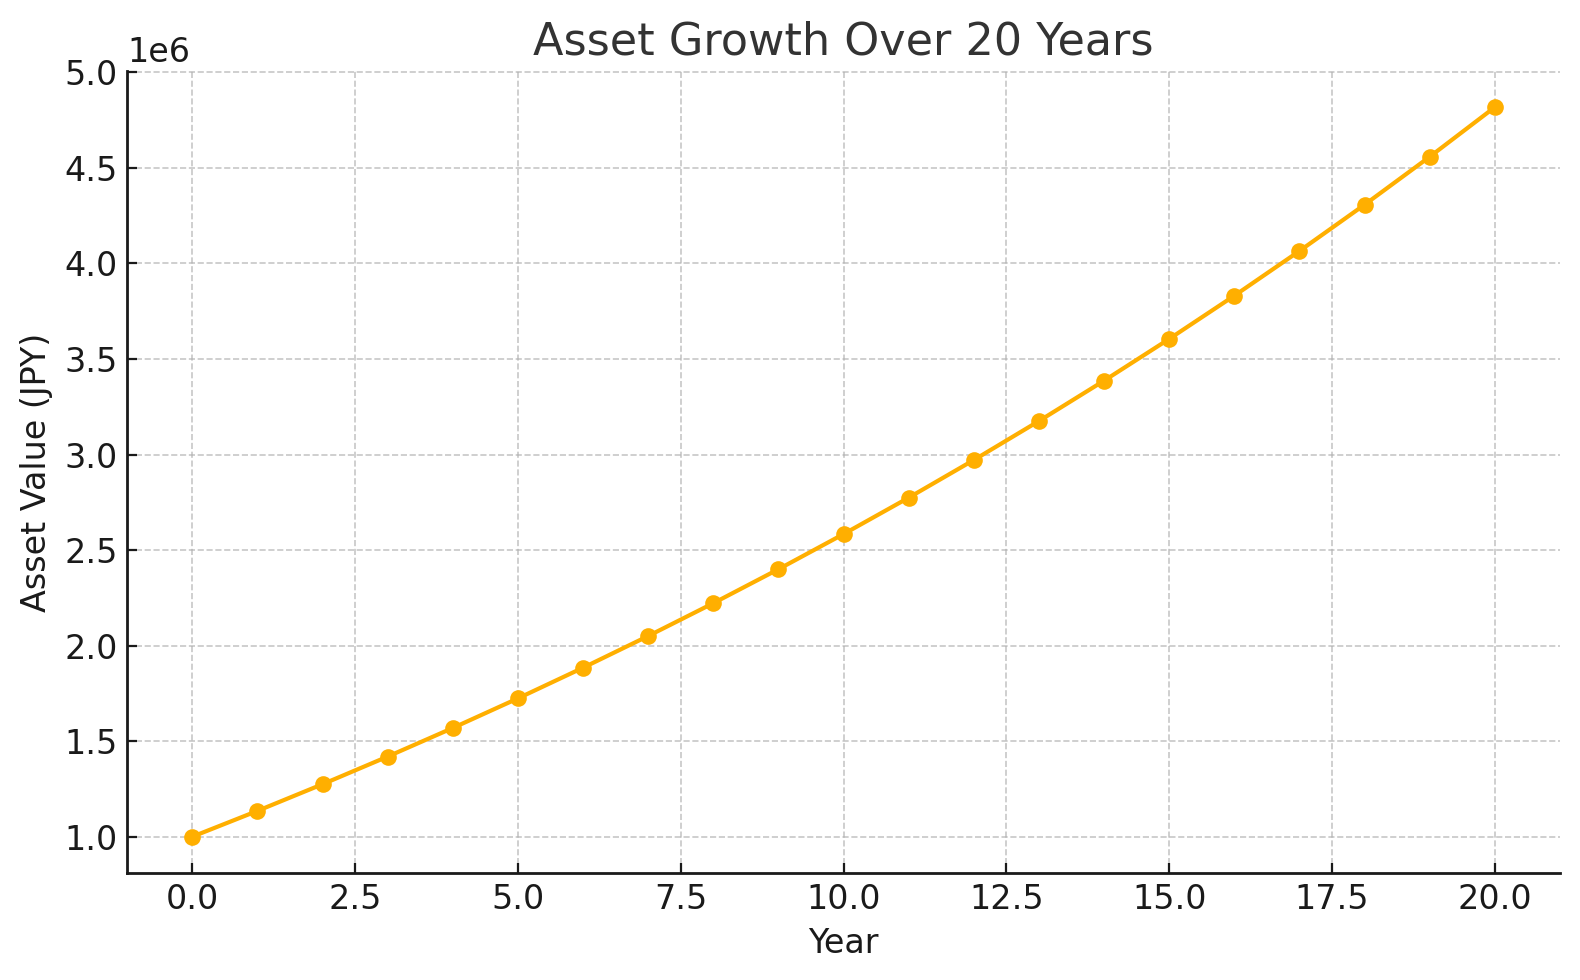

In [ ]:
# メッセージの追加
user_message_02 = "グラフで出力して下さい。"

message = project_client.agents.messages.create(
    thread_id=thread.id,
    role="user",
    content=user_message_02,
)


# Run の実行
run = project_client.agents.runs.create_and_process(
    thread_id=thread.id,
    agent_id=code_interpreter_agent.id
)


# Run の結果を確認
if run.status == "failed":
    print(f"Run failed: {run.last_error}")
else:
    agent_run_outputs(thread.id, project_client)

※ ここで、Azure AI Foundry 上の Web UI からエージェントのトレースを確認してみよう。

## Agent ID を .env ファイルに保存
※ 今回作成したエージェントを、後続の Connected Agents のハンズオン演習で使用するため永続化します。

In [12]:
# 変数の定義
agent_env_key = "FOUNDRY_CODE_INTERPRETER_AGENT_ID"
agent_env_value = code_interpreter_agent.id

# .envファイルのパスを自動探索
env_path = find_dotenv()  # 見つからなければ''を返す
if not env_path:
    raise FileNotFoundError(".envファイルが見つかりませんでした。")

# AGENT_ID を .env ファイルに追記
with open(env_path, "a", encoding="utf-8") as f:
    f.write(f'\n{agent_env_key}="{agent_env_value}"')

print(f'.envファイルに {agent_env_key}=\"{agent_env_value}\" を追記しました。')

# .envの自動読み込み（以降os.environで参照可能）
load_dotenv(env_path)


.envファイルに FOUNDRY_CODE_INTERPRETER_AGENT_ID="asst_ZownqF9PWOVZFqkvOIzW2P4k" を追記しました。


True